# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)


# Определяем, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Чернышёв".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с \
помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)


Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log\left(\sigma(y^{(i)} g(x^{(i)}))\right)\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log\left(\sigma(y^{(i)} g(x^{(i)}))\right)\right] + \frac{1}{C}\sum_{j=1}^{m}w_j^2 $$

$$ \frac{\partial L}{\partial w_k} = -\frac{1}{N}\left[ \sum\limits_i \frac{\sigma(y^{(i)}g(x^{(i)}))'_{w_k}}{\sigma(y^{(i)}g(x^{(i)}))} \right] + \frac{2}{C}w_k = $$
$$-\frac{1}{N}\left[ \sum\limits_i \frac{\sigma(y^{(i)}g(x^{(i)}))(1-\sigma(y^{(i)}g(x^{(i)})))}{\sigma(y^{(i)}g(x^{(i)}))} (y^{(i)}g(x^{(i)}))'_{w_k} \right] + \frac{2}{C}w_k = $$
$$-\frac{1}{N}\left[ \sum\limits_i (1-\sigma(y^{(i)}g(x^{(i)}))) y^{(i)}x^{(i)}_k \right] + \frac{2}{C}w_k$$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=1, max_epoch=15, cnt_batches=15):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.cnt_batches = cnt_batches  # количество батчей
        self.w = None                   # веса
        self.loss = None                # значения функции потерь

    # Сигма-функция
    def sigma(self, x):
        return 1 / (1 + np.exp(-x))

    # Логистическая функция потерь
    def log_loss(self, X, y):
        return -np.sum(np.log(self.sigma(y * (self.w * X).sum(axis=1)))) / \
            X.shape[0] + (self.w ** 2).sum() / self.C / 1000

    def fit(self, X_original, y_original=None):
        '''
        Обучение модели
        '''

        X = np.copy(X_original)
        y = np.copy(y_original)

        # Добавили единичный столбец в X (для w_0)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        # Инициализируем веса единицами
        self.w = np.ones(X.shape[1], dtype=float)
        # Инициализируем значения ф-ии потерь нулями
        self.loss = np.zeros(self.max_epoch)

        # Приводим все классы к 1 и -1
        y[y == 0] = -1

        alpha = self.alpha
        for epoch_number in xrange(self.max_epoch):
            # Берем случайные индексы
            inds = np.random.permutation(X.shape[0])

            # Разбили данные на батчи
            X_batches = np.array_split(X[inds], self.cnt_batches)
            y_batches = np.array_split(y[inds], self.cnt_batches)

            for i in xrange(self.cnt_batches):
                # Считаем градиент
                grad = -((y_batches[i] * (1 - self.sigma(y_batches[i] *
                         (self.w * X_batches[i]).sum(axis=1))))
                         .reshape(-1, 1) * X_batches[i]).sum(axis=0) / \
                        y_batches[i].size + 2 * self.w / self.C / 1000

                # Обновляем веса и скорость спуска
                self.w = self.w - alpha * grad
                alpha *= 0.99

            # Сохраняем знаячение ф-ии потерь
            self.loss[epoch_number] = self.log_loss(X, y)

        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''

        return (self.predict_proba(X)[0] >= 0.5).astype(int)

    def predict_proba(self, X_original):
        '''
        Возвращение вероятности каждого из классов
        '''

        X = np.hstack((np.ones((X_original.shape[0], 1)), X_original))
        p = self.sigma(np.dot(X, self.w)).reshape(-1, 1)
        return np.hstack((p, 1 - p))


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

w_0 = -3.76836025492
w_1 = 0.917987606663
w_2 = -0.902480124526


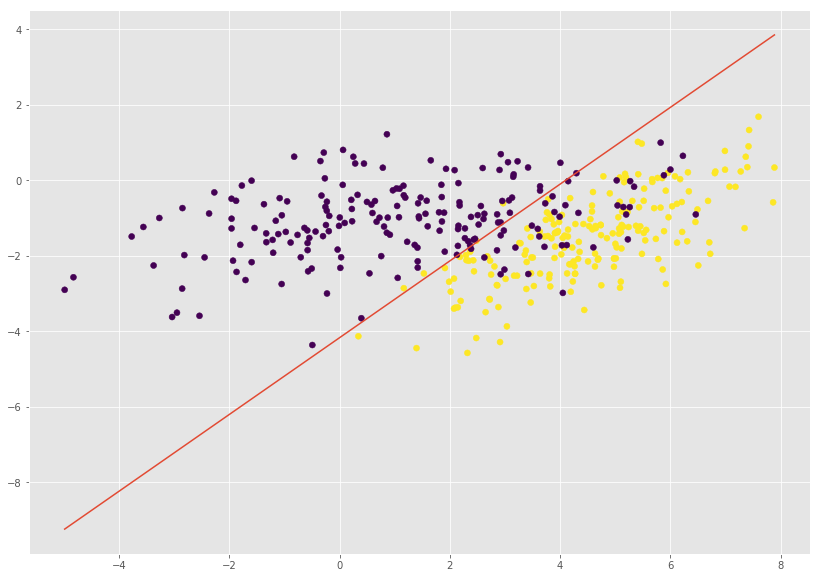

In [4]:
# Настроили размер графика
plt.figure(figsize=(14, 10))

np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:, 0], X[:, 1], c=y)

# Обучаем модель
SGDC = MySGDClassifier(C=1)
SGDC.fit(X, y)

# Выводим веса
for (i, w) in enumerate(SGDC.w):
    print 'w_{} = {}'.format(i, w)

# Рисуем разделяющую прямую по двум концам
x_out = np.linspace(X[:, 0].min(), X[:, 0].max(), num=2)
plt.plot(x_out, -(SGDC.w[0] + SGDC.w[1] * x_out) / SGDC.w[2])
plt.show()


## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [5]:
from sklearn.datasets import make_classification


In [6]:
X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)


Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

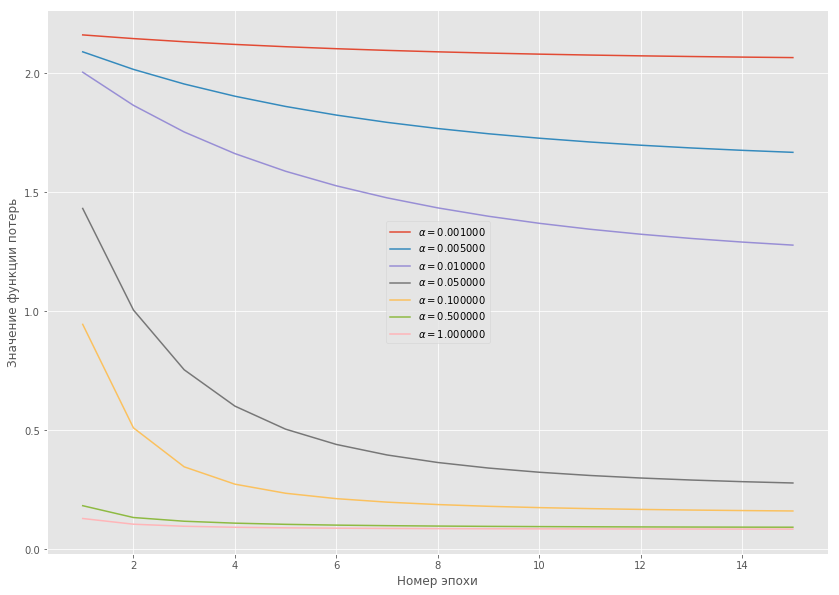

In [7]:
fig = plt.figure(figsize=(14, 10))
plt.xlabel(u'Номер эпохи')
plt.ylabel(u'Значение функции потерь')

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]:
    ax = fig.add_subplot(1, 1, 1)
    SGDC = MySGDClassifier(C=1, alpha=alpha)
    SGDC.fit(X, y)
    ax.plot(range(1, SGDC.max_epoch + 1), SGDC.loss,
            label=r'$\alpha=%f$' % alpha)

plt.legend()
plt.show()


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

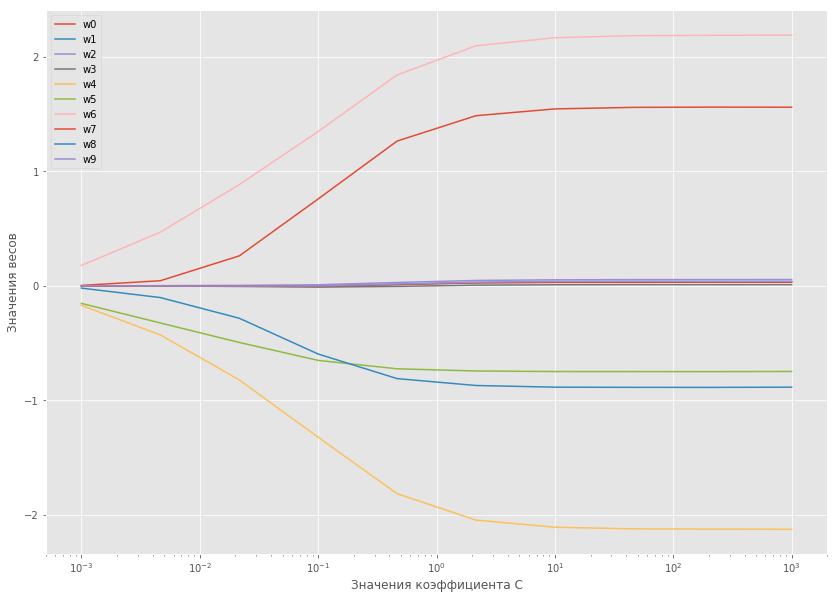

In [8]:
C = np.logspace(3, -3, 10)

fig = plt.figure(figsize=(14, 10))
plt.xlabel(u'Значения коэффициента C')
plt.ylabel(u'Значения весов')

weights = np.zeros((0, X.shape[1] + 1))
for i, c in enumerate(C):
    SGDC = MySGDClassifier(C=c)
    SGDC.fit(X, y)
    weights = np.concatenate((weights, SGDC.w.reshape(1, -1)), axis=0)

for i in xrange(weights.shape[0]):
    ax = fig.add_subplot(1, 1, 1)
    ax.semilogx(C, weights[:, i], label='w{}'.format(i))

plt.legend()
plt.show()


# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [9]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')


In [10]:
df_data.shape


(500000, 45)

In [11]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')


In [12]:
df_data.head().T


gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [13]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну


0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [14]:
print u'Число уникальных карт героя у игрока: {}'.format(
    np.unique(df_data.player_hero_card_id).size)
print u'Число уникальных карт героя у оппонента: {}'.format(
    np.unique(df_data.opponent_hero_card_id).size)

# Преобразование категориальных переменных
df = pd.get_dummies(df_data, columns=['opponent_hero_card_id',
                                      'player_hero_card_id'])


Число уникальных карт героя у игрока: 9
Число уникальных карт героя у оппонента: 9


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [15]:
X = df.loc[:, df.columns != 'decision'].values.astype(float)
y = df.decision.values

model = Pipeline([
    ('Scaler', StandardScaler()),
    ('Classifier', MySGDClassifier()),
])

model.fit(X, y)


Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Classifier', MySGDClassifier(C=1, alpha=1, cnt_batches=15, max_epoch=15))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [16]:
def read_data(filepath):
    global X, y
    df_data = pd.read_csv(filepath, sep=',')
    df_data.columns = df_data.columns.str.replace('.', '_')
    df_data = df_data.set_index('gamestate_id')
    df = pd.get_dummies(df_data, columns=['opponent_hero_card_id',
                                          'player_hero_card_id'])
    X = df.loc[:, df.columns != 'decision'].values.astype(float)
    y = df.decision.values

read_data('./trainingData_tabular_chunk2.csv')
model.fit(X, y)

read_data('./trainingData_tabular_chunk3.csv')
print u'ROC-AUC: {}'.format(roc_auc_score(y, model.predict_proba(X)[:, 0]))


ROC-AUC: 0.782288643747
